<a href="https://colab.research.google.com/github/priaJuli/Project-ML-Dicoding/blob/master/Time_series_submission_Dicoding_Climate_IDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link dataset :  

https://github.com/priaJuli/Project-ML-Dicoding/blob/master/climate-idn.zip

Sumber dataset

https://www.kaggle.com/datasets/greegtitan/indonesia-climate/data

In [1]:
import zipfile,os

datasetpath = '/content/climate-idn.zip'

if not os.path.isfile(datasetpath):
    !wget "https://raw.githubusercontent.com/priaJuli/Project-ML-Dicoding/master/climate-idn.zip"
    !unzip '/content/climate-idn.zip'

In [2]:
import random

def get_datas_by_random_station_id(df, station_arr, mins_data=2000):
    station_id = random.choice(station_arr)
    data = df[df['station_id'] == station_id].dropna()

    if len(data) >= mins_data:
        return data
    else:
        return get_datas_by_random_station_id(df, station_arr, mins_data)

# Notes

Label (y) yang digunakan adalah Rata-rata temperature (Tavg)

Features yang digunakan :
1. Pengukuran Temperature Minimum (Tn),
2. Pengukuran Temperature Maximum (Tx),
3. Rata-rata temperature Lag1,
4. Rata-rata temperature Lag2

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from keras.layers import Dense, LSTM
import tensorflow as tf
from sklearn.model_selection import train_test_split


path_train = "/content/climate-idn/climate_data.csv"

## Loading data
df = pd.read_csv(path_train, parse_dates=['date'], dayfirst=True).dropna()

station_arr = df['station_id'].unique()

## Get only 1 station
dfselected = get_datas_by_random_station_id(df, station_arr)
dfselected.set_index(['date'])

threshold = (dfselected['Tavg'].max() - dfselected['Tavg'].min()) * 0.1

print("Max {}, Min {}, Threshold {}".format(dfselected['Tavg'].max() , dfselected['Tavg'].min(), threshold))

Max 29.5, Min 22.9, Threshold 0.6600000000000001


In [31]:
np.median([7, 1, 4, 8, 2, 3, 5])

4.0

In [4]:
data = dfselected.copy()
data = data[['date', 'Tn', 'Tx', 'Tavg']]

lag1 = data['Tavg'].shift(1)
lag2 = data['Tavg'].shift(2)

data['Tavglag1'] = lag1
data['Tavglag2'] = lag2

data = data.dropna()

train_df, test_df = train_test_split(data, test_size=0.2, shuffle=False)

In [5]:
train_df.set_index('date', inplace=True)

train_df.head()

,Tn,Tx,Tavg,Tavglag1,Tavglag2
date,,,,,
2010-01-04,24.0,27.4,25.6,26.7,26.7
2010-01-05,24.0,30.4,26.9,25.6,26.7
2010-01-06,24.0,30.2,25.7,26.9,25.6
2010-01-07,24.0,30.0,26.1,25.7,26.9
2010-01-08,24.0,29.8,26.5,26.1,25.7


In [6]:
train_df.shape

(2302, 5)

In [7]:
test_df.shape

(576, 6)

In [8]:
test_df.set_index('date', inplace=True)
test_df.head()

,Tn,Tx,Tavg,Tavglag1,Tavglag2
date,,,,,
2019-01-28,23.8,28.8,25.7,27.5,26.9
2019-01-29,23.8,30.7,27.6,25.7,27.5
2019-01-30,25.0,30.4,27.3,27.6,25.7
2019-01-31,24.0,31.6,27.0,27.3,27.6
2019-02-02,24.0,30.8,27.1,27.0,27.3


ADA 2 SCALER, 1 UNTUK FEATURES, 1 UNTUK LABEL

In [9]:
## train
X_train = train_df[['Tn', 'Tx', 'Tavglag1', 'Tavglag2']].values
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))

y_train = train_df['Tavg'].values
y_train = y_train.reshape(-1, 1)

## Test
X_test = test_df[['Tn', 'Tx', 'Tavglag1', 'Tavglag2']].values
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))

y_test = test_df['Tavg'].values
y_test = y_test.reshape(-1, 1)
# y_test = scalerlabel.fit_transform(y_test)

In [10]:
X_train[0]

array([24. , 27.4, 26.7, 26.7])

In [11]:
X_train.shape

(2302, 4)

In [12]:
y_train[0:4]

array([[25.6],
       [26.9],
       [25.7],
       [26.1]])

In [13]:
print(X_train.shape)

(2302, 4)


In [14]:

## Create custom callbacks for stopping criteria
class ValidationMax(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ValidationMax, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):

        if (logs["mae"] < self.threshold) and logs["val_mae"] < self.threshold:
            self.model.stop_training = True
            print("")
            print("Epoch {}: Stop training because validation mae reach less than {}, Val MAE = {:7.2f}".format(epoch+1, (self.threshold ), logs["val_mae"]))

In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64,  return_sequences=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
])

print("Threshold ", threshold)
stopmax = ValidationMax(threshold=threshold)

optimizer = tf.keras.optimizers.Adam(learning_rate=1.0000e-03)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

## Reshape to fit into LSTM NN
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[stopmax])

Threshold  0.6600000000000001
Epoch 1/50
72/72 [==============================] - 30s 68ms/step - loss: 18.1944 - mae: 18.6887 - val_loss: 1.9623 - val_mae: 2.4599
Epoch 2/50
72/72 [==============================] - 1s 20ms/step - loss: 0.6274 - mae: 1.0237 - val_loss: 0.4437 - val_mae: 0.8281
Epoch 3/50
72/72 [==============================] - 1s 19ms/step - loss: 0.4300 - mae: 0.8040 - val_loss: 0.4668 - val_mae: 0.8579
Epoch 4/50
72/72 [==============================] - 1s 9ms/step - loss: 0.4216 - mae: 0.7973 - val_loss: 0.3885 - val_mae: 0.7645
Epoch 5/50
72/72 [==============================] - 1s 7ms/step - loss: 0.3699 - mae: 0.7299 - val_loss: 0.3090 - val_mae: 0.6622
Epoch 6/50
72/72 [==============================] - 1s 8ms/step - loss: 0.3417 - mae: 0.6951 - val_loss: 0.4486 - val_mae: 0.8358
Epoch 7/50
72/72 [==============================] - 1s 8ms/step - loss: 0.3148 - mae: 0.6628 - val_loss: 0.3232 - val_mae: 0.6834
Epoch 8/50
72/72 [==============================] - 1s

In [16]:
print("Max {}, MIn {}".format(np.amax(y_test) , np.amin(y_test)))
(np.amax(y_test) - np.amin(y_test)) * 0.1

Max 29.3, MIn 23.9


0.5400000000000003

In [17]:
y_pred = model.predict(X_test)

18/18 [==============================] - 2s 4ms/step


In [18]:
y_test[0:5]

array([[25.7],
       [27.6],
       [27.3],
       [27. ],
       [27.1]])

In [19]:
y_pred[0:5]

array([[26.34867 ],
       [27.016602],
       [27.185076],
       [27.309864],
       [27.118784]], dtype=float32)

In [20]:
from sklearn.metrics import mean_absolute_error

MAE = mean_absolute_error(y_test, y_pred)

In [21]:
print("Model MAE ", MAE)

Model MAE  0.5670709914631316


In [22]:
print("Model MAE ", np.average(np.abs(y_test - y_pred)))

Model MAE  0.5670709914631316


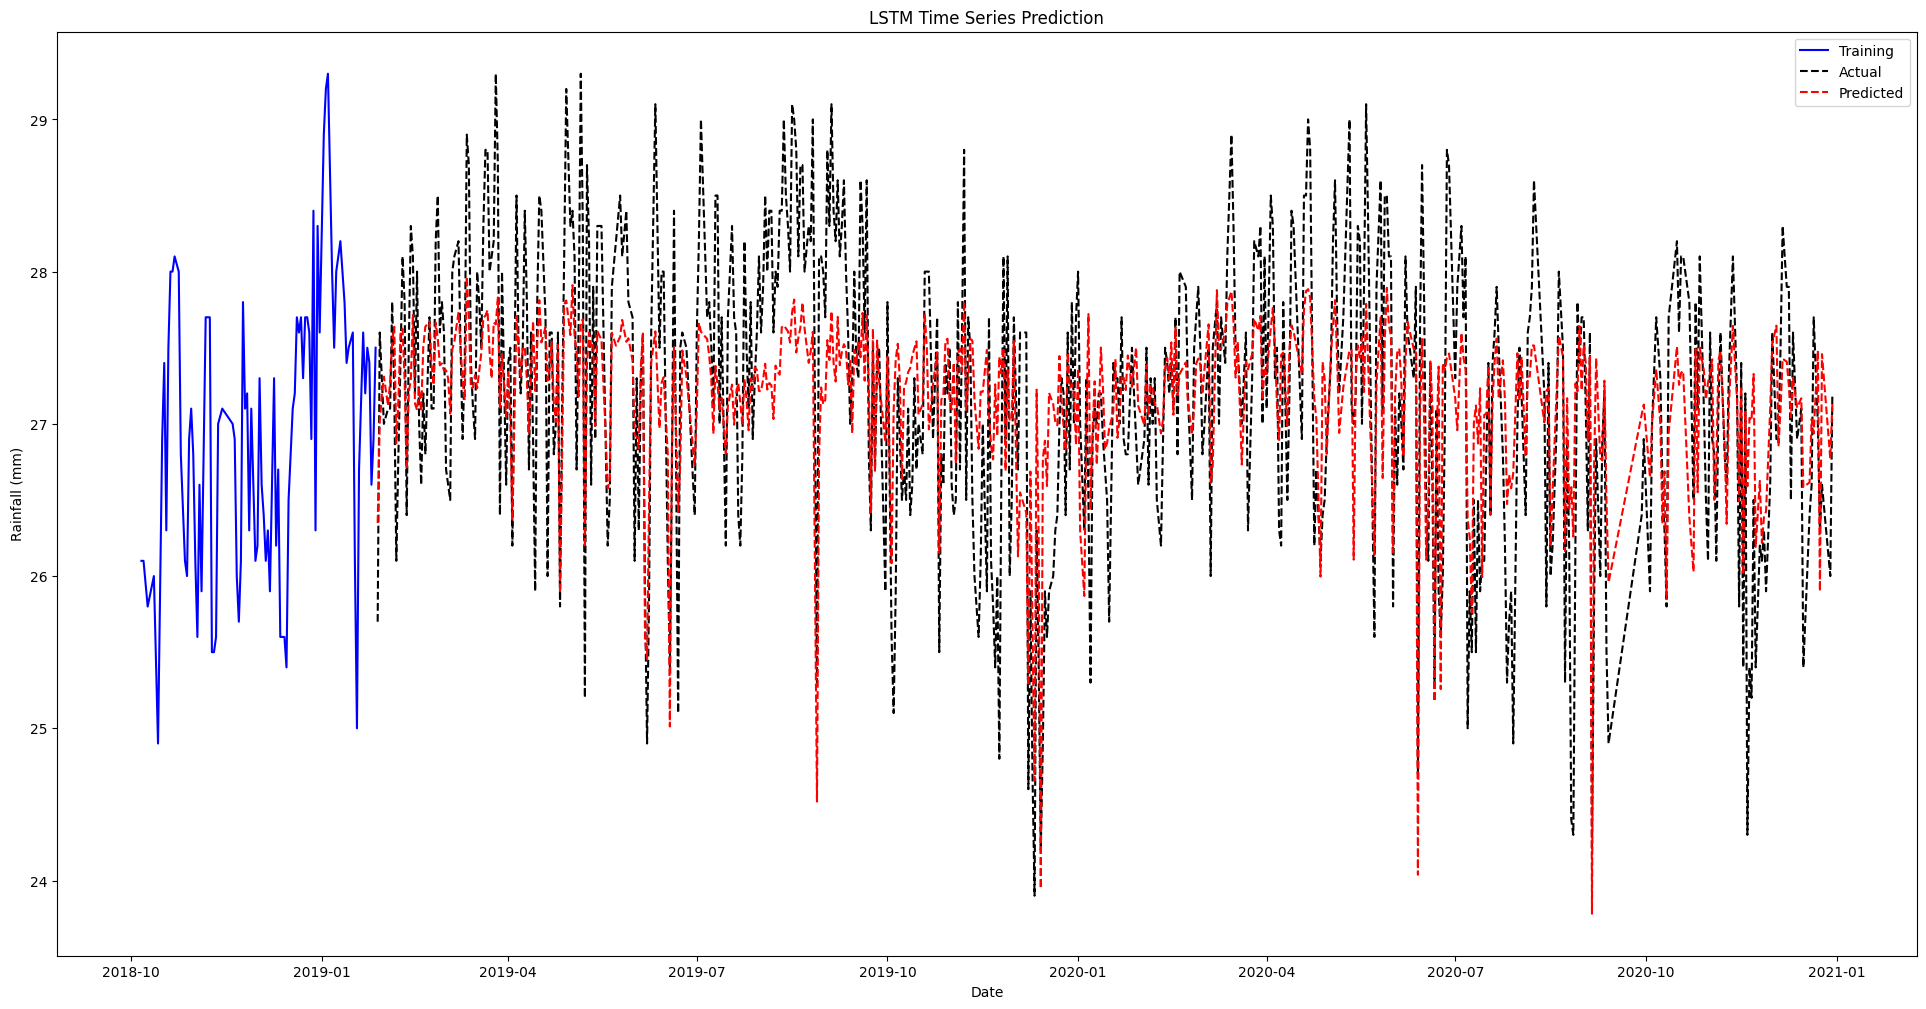

In [30]:
plt.figure(figsize=(24, 12))

# Plot temperature for training data
plt.plot(train_df[-90:].index, y_train[-90:], label='Training', color='blue')

# Plot actual values
plt.plot(test_df.index, y_test, label='Actual', color='black', linestyle='dashed')

# Plot predicted values
plt.plot(test_df.index, y_pred, label='Predicted', color='red', linestyle='dashed')

plt.title('LSTM Time Series Prediction')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()

In [24]:
test_df['Pred Tavg'] = y_pred
test_df.head()

,Tn,Tx,Tavg,Tavglag1,Tavglag2,Pred Tavg
date,,,,,,
2019-01-28,23.8,28.8,25.7,27.5,26.9,26.348669
2019-01-29,23.8,30.7,27.6,25.7,27.5,27.016602
2019-01-30,25.0,30.4,27.3,27.6,25.7,27.185076
2019-01-31,24.0,31.6,27.0,27.3,27.6,27.309864
2019-02-02,24.0,30.8,27.1,27.0,27.3,27.118784


In [25]:
test_df.to_csv("Test.csv")

END CODING